<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/main/Alexnet_grand_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim

In [3]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))

Number of image paths: 300
Number of labels: 300


In [4]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(degrees=[-15, 15]),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [5]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
num_epochs=5
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [7]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [8]:
net = torchvision.models.alexnet(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 223MB/s]


==========Cross Validation Fold <generator object _BaseKFold.split at 0x7ceb62ab50e0>==========
trainLoss: 0.6945 Acc: 0.6000
valLoss: 0.5847 Acc: 0.7667
trainLoss: 0.5867 Acc: 0.7375
valLoss: 0.5412 Acc: 0.7667
trainLoss: 0.5728 Acc: 0.7500
valLoss: 0.5261 Acc: 0.7667
trainLoss: 0.5527 Acc: 0.7583
valLoss: 0.5181 Acc: 0.7667
trainLoss: 0.5289 Acc: 0.7542
valLoss: 0.5013 Acc: 0.7667


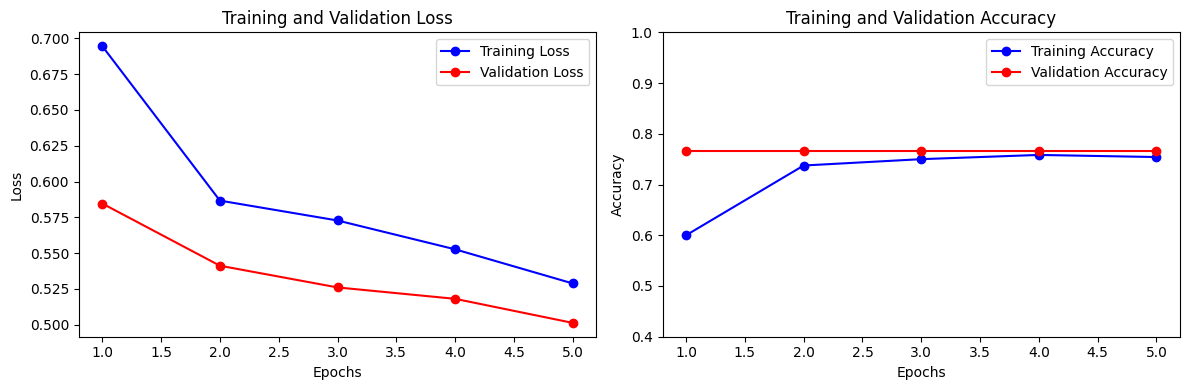

Train done.
Average Training Loss: 0.5871223529179891
Average Training Accuracy: 0.72
Average Validation Loss: 0.534290848573049
Average Validation Accuracy: 0.7666666666666667
Train saved.
==========Cross Validation Fold <generator object _BaseKFold.split at 0x7ceb62ab6730>==========
trainLoss: 0.5625 Acc: 0.7500
valLoss: 0.5562 Acc: 0.7333
trainLoss: 0.5360 Acc: 0.7750
valLoss: 0.5358 Acc: 0.7500
trainLoss: 0.5030 Acc: 0.7667
valLoss: 0.5209 Acc: 0.7667
trainLoss: 0.5221 Acc: 0.7708
valLoss: 0.5058 Acc: 0.7667
trainLoss: 0.5154 Acc: 0.7833
valLoss: 0.5000 Acc: 0.7667


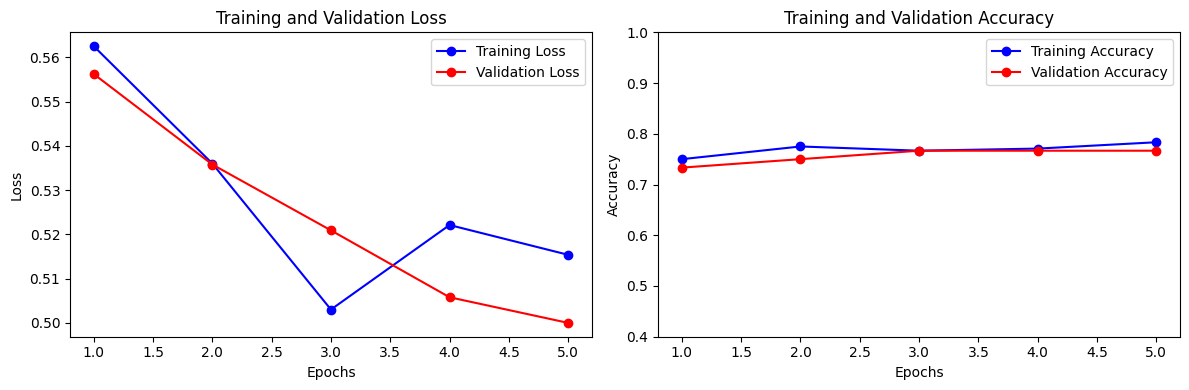

Train done.
Average Training Loss: 0.5277844806512197
Average Training Accuracy: 0.7691666666666667
Average Validation Loss: 0.5237191092967988
Average Validation Accuracy: 0.7566666666666666
Train saved.
==========Cross Validation Fold <generator object _BaseKFold.split at 0x7ceb6ba78e40>==========
trainLoss: 0.5810 Acc: 0.7208
valLoss: 0.4884 Acc: 0.8000
trainLoss: 0.5339 Acc: 0.7458
valLoss: 0.4692 Acc: 0.8000
trainLoss: 0.5249 Acc: 0.7458
valLoss: 0.4635 Acc: 0.8000
trainLoss: 0.4913 Acc: 0.7667
valLoss: 0.4570 Acc: 0.8000
trainLoss: 0.4726 Acc: 0.7667
valLoss: 0.4535 Acc: 0.8000


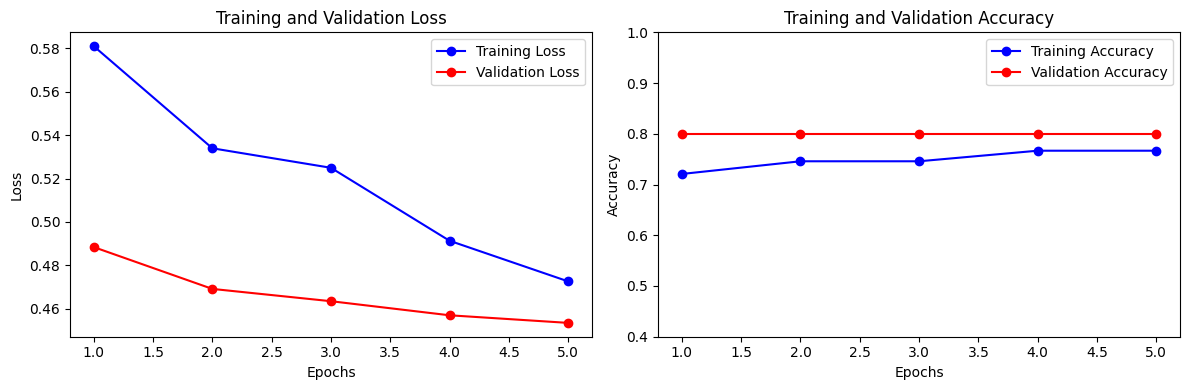

Train done.
Average Training Loss: 0.5207650585969289
Average Training Accuracy: 0.7491666666666668
Average Validation Loss: 0.4663302828868231
Average Validation Accuracy: 0.8
Train saved.
==========Cross Validation Fold <generator object _BaseKFold.split at 0x7ceb7a19c820>==========
trainLoss: 0.5581 Acc: 0.7417
valLoss: 0.5255 Acc: 0.8000
trainLoss: 0.5278 Acc: 0.7792
valLoss: 0.5161 Acc: 0.7667
trainLoss: 0.5180 Acc: 0.7625
valLoss: 0.4995 Acc: 0.8000
trainLoss: 0.4927 Acc: 0.7750
valLoss: 0.5101 Acc: 0.8000
trainLoss: 0.5001 Acc: 0.7792
valLoss: 0.4831 Acc: 0.8500


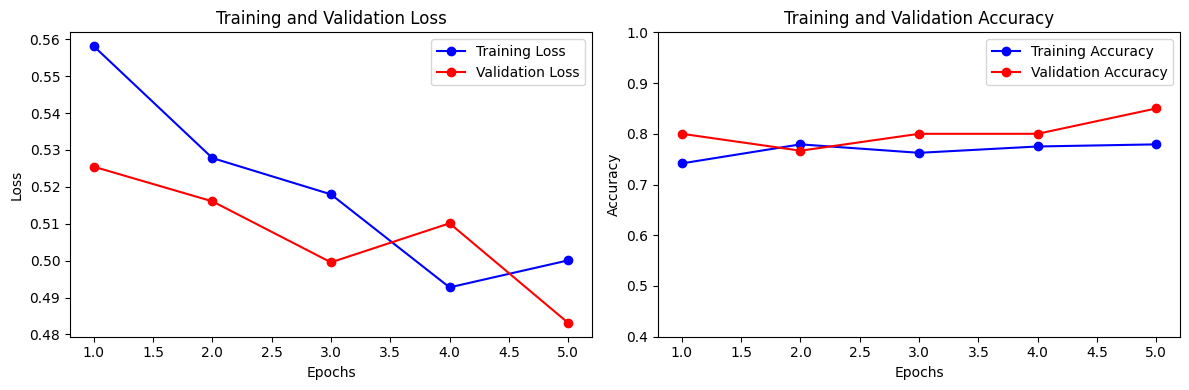

Train done.
Average Training Loss: 0.5193407348791759
Average Training Accuracy: 0.7675
Average Validation Loss: 0.5068591882785162
Average Validation Accuracy: 0.8033333333333333
Train saved.
==========Cross Validation Fold <generator object _BaseKFold.split at 0x7ceb62ab5230>==========
trainLoss: 0.7622 Acc: 0.5458
valLoss: 0.5426 Acc: 0.7667
trainLoss: 0.5671 Acc: 0.7458
valLoss: 0.5231 Acc: 0.7667
trainLoss: 0.5452 Acc: 0.7583
valLoss: 0.5164 Acc: 0.7667
trainLoss: 0.5480 Acc: 0.7500
valLoss: 0.5066 Acc: 0.7667
trainLoss: 0.5068 Acc: 0.7625
valLoss: 0.4868 Acc: 0.7667


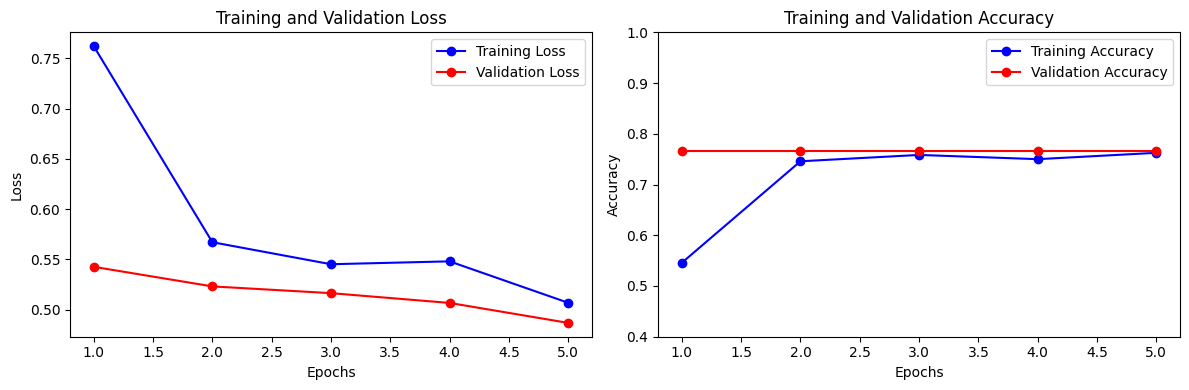

Train done.
Average Training Loss: 0.5858414177099863
Average Training Accuracy: 0.7125
Average Validation Loss: 0.5150812834501267
Average Validation Accuracy: 0.7666666666666667
Train saved.


In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths), 1):
    print(f'==========Cross Validation Fold {kfold.split(image_paths)}==========')
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.classifier[6] = nn.Linear(4096, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    # 全エポックの平均損失と平均精度を計算
    average_train_loss = sum(train_losses) / num_epochs
    average_train_acc = sum(train_accs) / num_epochs
    average_val_loss = sum(val_losses) / num_epochs
    average_val_acc = sum(val_accs) / num_epochs
    average_train_acc_cpu = average_train_acc.cpu().numpy()
    average_val_acc_cpu = average_val_acc.cpu().numpy()
    # 結果を表示
    print("Average Training Loss:", average_train_loss)
    print("Average Training Accuracy:", average_train_acc_cpu)
    print("Average Validation Loss:", average_val_loss)
    print("Average Validation Accuracy:", average_val_acc_cpu)

    torch.save(model.state_dict(), file_path)
    print('Train saved.')

In [ ]:
model.load_state_dict(torch.load(r'/content/drive/MyDrive/learning/weight/alexnet.pth'))
print('Train loaded.')